## Task 2 - Predicting Customers Buying Behaviour

In [1]:
%matplotlib inline 

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = "customer_booking .csv"

In [3]:
import chardet

with open("customer_booking .csv", 'rb') as rawdata:
    result =  chardet.detect(rawdata.read(100000))

print(result)

{'encoding': 'ISO-8859-1', 'confidence': 0.73, 'language': ''}


In [4]:
df = pd.read_csv(data, encoding = 'ISO-8859-1')
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


In [5]:
df.dtypes

num_passengers             int64
sales_channel             object
trip_type                 object
purchase_lead              int64
length_of_stay             int64
flight_hour                int64
flight_day                object
route                     object
booking_origin            object
wants_extra_baggage        int64
wants_preferred_seat       int64
wants_in_flight_meals      int64
flight_duration          float64
booking_complete           int64
dtype: object

In [6]:
df.shape 

(50000, 14)

In [7]:
#check for null values 

df.isnull().sum()



num_passengers           0
sales_channel            0
trip_type                0
purchase_lead            0
length_of_stay           0
flight_hour              0
flight_day               0
route                    0
booking_origin           0
wants_extra_baggage      0
wants_preferred_seat     0
wants_in_flight_meals    0
flight_duration          0
booking_complete         0
dtype: int64

In [8]:
df.booking_complete.value_counts()

booking_complete
0    42522
1     7478
Name: count, dtype: int64

In [11]:
# Seperate the feature (X) and the target function (y)

X = df.drop('booking_complete', axis=1)
y = df['booking_complete']

# convert object dtype columns to int dtype 
for colname in X.select_dtypes(include='object'):
    #Factorize categorical column and replace it in X 
    X[colname], _ = X[colname].factorize()

In [12]:
X.dtypes

num_passengers             int64
sales_channel              int64
trip_type                  int64
purchase_lead              int64
length_of_stay             int64
flight_hour                int64
flight_day                 int64
route                      int64
booking_origin             int64
wants_extra_baggage        int64
wants_preferred_seat       int64
wants_in_flight_meals      int64
flight_duration          float64
dtype: object

In [13]:
from sklearn.feature_selection import mutual_info_classif

mi_scores = mutual_info_classif(X,y)
mi_scores = pd.Series(mi_scores, name="MI scores", index=X.columns) 
mi_scores = mi_scores.sort_values(ascending=False)

# Dispaly a few features with their Mi scores
mi_scores

route                    0.052905
booking_origin           0.048349
flight_duration          0.017969
wants_extra_baggage      0.009431
length_of_stay           0.008674
wants_preferred_seat     0.004283
wants_in_flight_meals    0.003568
num_passengers           0.002934
purchase_lead            0.002328
flight_hour              0.002051
sales_channel            0.001784
flight_day               0.000547
trip_type                0.000000
Name: MI scores, dtype: float64

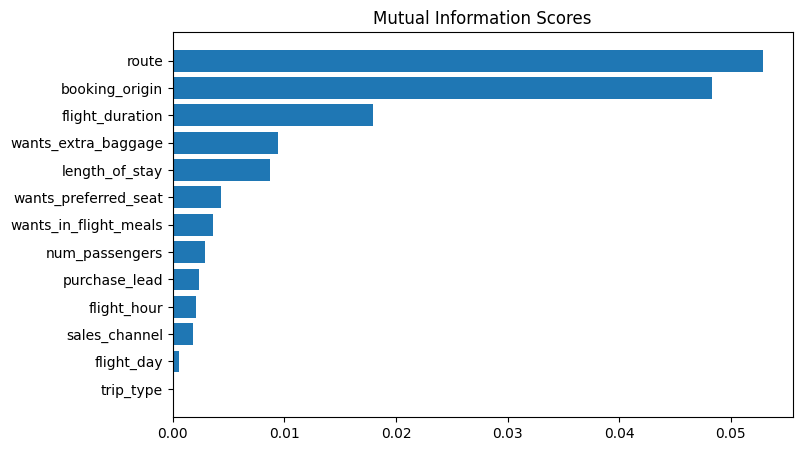

In [20]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

plt.figure(dpi=100, figsize=(8,5))
plot_mi_scores(mi_scores)

In [37]:
#test train split 

from sklearn.model_selection import train_test_split

#dataset split
#creating a function for dataset split 
def dataset(X,y):
    train_full_X, val_X, train_full_y, val_y = train_test_split(X, y, test_size=0.2, random_state=0)

# use the same function above for the validation set 
    train_X, test_X, train_y, test_y = train_test_split(train_full_X, train_full_y, test_size=0.25, random_state=0)
    return(train_X, val_X, train_y, val_y)

In [38]:
from sklearn.preprocessing import MinMaxScaler

def scale(X):
    scaler = MinMaxScaler() 
    scaler.fit(X)
    return X

# Model 1: Random forest classifier with top 6 features

In [39]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import scale 

#assigning the features under a list 

features=['route', 'booking_origin', 'flight_duration', 'wants_extra_baggage', 'length_of_stay', 'num_passengers']
X = df[features]
#one hot encoding
X = pd.get_dummies(X, columns=features)
X = scale(X)
y= df.booking_complete

X_train, X_val, y_train, y_val = dataset(X,y)

forest_model = RandomForestClassifier(random_state=1)
forest_model.fit(X_train, y_train)
preds=forest_model.predict(X_val)

print('Accuracy: ', accuracy_score(y_val, preds) * 100)
print('Auc score: ', roc_auc_score(y_val, preds))


Accuracy:  83.36
Auc score:  0.5657818407546988


# Model 2 : Random forest classifier with all features 

In [41]:
X = df.drop('booking_complete', axis=1)
#one hot encoding 
X = pd.get_dummies(X)
X = scale(X)
y =  df.booking_complete

X_train, X_val, y_train, y_val = dataset(X,y)

forest_model =  RandomForestClassifier(random_state=1)
forest_model.fit(X_train, y_train)
preds= forest_model.predict(X_val)

print('ACCURACY: ', accuracy_score(y_val, preds)*100)
print('AUC score: ', roc_auc_score(y_val,preds))

ACCURACY:  84.77
AUC score:  0.548019322113966


Using random forest model with all features as final model, as it has good accuracy and higher acu score when compared to other models 

Validating with test data set 

In [43]:
X =  df.drop('booking_complete', axis=1)
#one hot encoding 
X =  pd.get_dummies(X)
X = scale(X)
y =  df.booking_complete

train_full_X, test_X, train_full_y, test_y = train_test_split(X, y, test_size=0.2, random_state  = 0)

forest_model = RandomForestClassifier(random_state=1)
forest_model.fit(train_full_X, train_full_y)
preds= forest_model.predict(test_X)

print('ACCURACY: ', accuracy_score(test_y, preds) *100)
print('AUC score: ', roc_auc_score(test_y, preds))

ACCURACY:  85.08
AUC score:  0.5577207581035838
